In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import ast
from tqdm import tqdm
tqdm.pandas()


df = pd.read_csv("clean_data_filtered_15_score5.csv")
df = df.dropna(subset=['body','title','tag'])


X = (df['title'] + " " + df['body']).to_list()


df['tag'] = df['tag'].apply(ast.literal_eval)

# transform Y
y = df['tag']
multi_label_binarizer = MultiLabelBinarizer()
y = multi_label_binarizer.fit_transform(y)
y_classes = multi_label_binarizer.classes_




# Split data into train,tests and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.12, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.12, random_state=0)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize input texts
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=128, return_tensors="tf")
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=128, return_tensors="tf")
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=128, return_tensors="tf")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Modeling

In [5]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np

model_name = 'bert-base-uncased'

class BERTModel(tf.keras.Model):
    def __init__(self, num_labels, model_name):
        super(BERTModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name)
        self.dropout = Dropout(0.1)
        self.dense = Dense(num_labels, activation='sigmoid')

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # Using the pooled output (CLS token)
        pooled_output = self.dropout(pooled_output)
        logits = self.dense(pooled_output)
        return logits


model = BERTModel(15, model_name)

# Define model parameters and hyperparameters
batch_size = 16
num_epochs = 3
learning_rate = 2e-5
num_labels = 15



# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': X_train_tokenized['input_ids'], 'attention_mask': X_train_tokenized['attention_mask']}, y_train)).shuffle(len(X_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': X_val_tokenized['input_ids'], 'attention_mask': X_val_tokenized['attention_mask']}, y_val)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': X_test_tokenized['input_ids'], 'attention_mask': X_test_tokenized['attention_mask']}, y_test)).batch(batch_size)

# Instantiate BERT model
model = BERTModel(num_labels, model_name)

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
criterion = BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])

# Model training
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
2154/2154 [==============================] - 1016s 441ms/step - loss: 0.1171 - accuracy: 0.6756 - val_loss: 0.0843 - val_accuracy: 0.7637
Epoch 2/3
2154/2154 [==============================] - 943s 438ms/step - loss: 0.0696 - accuracy: 0.7891 - val_loss: 0.0781 - val_accuracy: 0.7699
Epoch 3/3
2154/2154 [==============================] - 943s 438ms/step - loss: 0.0507 - accuracy: 0.8367 - val_loss: 0.0818 - val_accuracy: 0.7772


In [6]:
model.save("filtered_15_score_5")

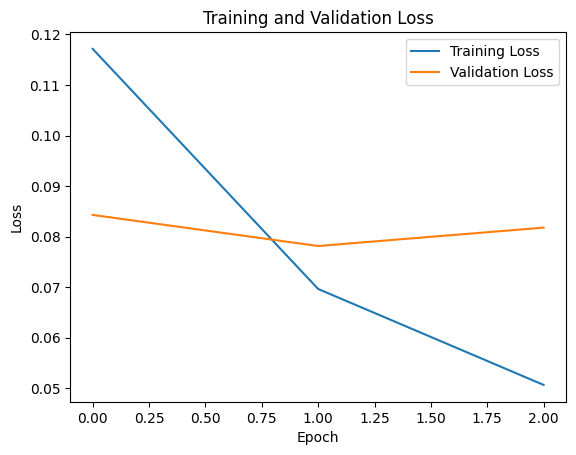

In [7]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

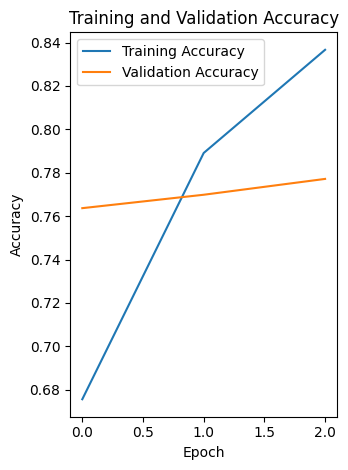

In [8]:
# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation

In [9]:
from tensorflow.keras.models import load_model

loaded_model = load_model("filtered_15_score_5")


In [10]:
from sklearn.metrics import classification_report, jaccard_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score

# Predict probabilities for validation data
y_test_pred_prob = model.predict(test_dataset)

# Threshold probabilities to obtain binary predictions
threshold = 0.5
y_test_pred = (y_test_pred_prob > threshold).astype(int)

# Convert binary predictions to original label format
y_test_pred_labels = multi_label_binarizer.inverse_transform(y_test_pred)

# Convert validation labels to original label format
y_test_labels = multi_label_binarizer.inverse_transform(y_test)

acc = accuracy_score(y_test, y_test_pred)
jacc_sc = jaccard_score(y_test, y_test_pred, average='weighted')
hamming_ls = hamming_loss(y_test, y_test_pred)

print(f"Hamming Loss: {hamming_ls:.4f}")
print(f'Jaccard Score: {jacc_sc:.4f}')

# Print classification report for each label
for i, label in enumerate(multi_label_binarizer.classes_):
    print(f"Classification Report for {label}:")
    print(classification_report([label in y for y in y_test_labels], [label in y for y in y_test_pred_labels]))


294/294 [==============================] - 53s 148ms/step
Hamming Loss: 0.0295
Jaccard Score: 0.6810
Classification Report for .net:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97      4384
        True       0.72      0.44      0.54       315

    accuracy                           0.95      4699
   macro avg       0.84      0.71      0.76      4699
weighted avg       0.94      0.95      0.95      4699

Classification Report for android:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99      4156
        True       0.96      0.94      0.95       543

    accuracy                           0.99      4699
   macro avg       0.98      0.97      0.97      4699
weighted avg       0.99      0.99      0.99      4699

Classification Report for c:
              precision    recall  f1-score   support

       False       0.98      0.99      0.99      4482
        True       0.74      0.67      0